<a href="https://colab.research.google.com/github/srilav/machinelearning/blob/main/M6_NB_MiniProject_4_AirQuality_Forecast_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Air quality forecasting using ARIMA

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARIMA model and forecast the air quality

## Information

ARIMA stands for auto-regressive integrated moving average. It’s a way of modelling time series data for forecasting (i.e., for predicting future points in the series), in such a way that:

* a pattern of growth/decline in the data is accounted for (“auto-regressive” part)
* the rate of change of the growth/decline in the data is accounted for (the “integrated” part)
* noise between consecutive time points is accounted for (the “moving average” part)

ARIMA models are typically expressed like “ARIMA(p,d,q)”, with the three terms p, d, and q defined as follows:

* p means the number of preceding (“lagged”) Y values that have to be added/subtracted to Y in the model, so as to make better predictions based on local periods of growth/decline in our data. This captures the “autoregressive” nature of ARIMA.

* d represents the number of times that the data have to be “differenced” to produce a stationary signal (i.e., a signal that has a constant mean over time). This captures the “integrated” nature of ARIMA. If d=0, this means that our data does not tend to go up/down in the long term (i.e., the model is already “stationary”). In this case, then technically you are performing just ARMA, not AR-I-MA. If p is 1, then it means that the data is going up/down linearly. If p is 2, then it means that the data is going up/down exponentially. More on this below…

* q represents the number of preceding/lagged values for the error term that are added/subtracted to Y. This captures the “moving average” part of ARIMA.



Refer to the basics of Air quality index [here](https://www.airnow.gov/aqi/aqi-basics/)

## Dataset



This dataset includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. Missing data are denoted as NA.

**Attributes Information:**

* No: row number
* year: year of data in this row 
* month: month of data in this row 
* day: day of data in this row 
* hour: hour of data in this row 
* PM2.5: PM2.5 concentration (ug/m^3) 

  Fine particulate matter (PM2.5) is an air pollutant that is a concern for people's health when levels in air are high. PM2.5 are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated 

* PM10: PM10 concentration (ug/m^3) 
* SO2: SO2 concentration (ug/m^3) 
* NO2: NO2 concentration (ug/m^3) 
* CO: CO concentration (ug/m^3) 
* O3: O3 concentration (ug/m^3) 
* TEMP: temperature (degree Celsius) 
* PRES: pressure (hPa) 
* DEWP: dew point temperature (degree Celsius) 
* RAIN: precipitation (mm) 
* wd: wind direction 
* WSPM: wind speed (m/s) 
* station: name of the air-quality monitoring site

**Dataset source:** https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

## Problem Statement

Implement ARIMA model to forecast the air quality using Beijing air quality dataset

## Grading = 10 Points

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/PRSA_Data_Nongzhanguan_20130301_20170228.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


In [ ]:
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5 MB 2.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


### Import required Packages 

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import expit, logit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools
from numpy import log
from matplotlib import pyplot, colors
from pandas.core.series import Series
from datetime import datetime

### Load the data and analyze (2 Points)

Refer to casestudy: [M6_NB_Case_Study_EDA_Air_Quality_Data](https://drive.google.com/file/d/1HAmSiWKgmRrHLQChY4DGyOI1ky2yPv6c/view?usp=sharing)

In [ ]:
file_name = "PRSA_Data_Nongzhanguan_20130301_20170228.csv"
# YOUR CODE HERE

In [ ]:
# defining a function for date time
def convert_to_date(x):
  return datetime.strptime(x, '%Y %m %d %H')

In [ ]:
df = pd.read_csv(file_name, parse_dates=[['year', 'month', 'day', 'hour']],date_parser=convert_to_date, keep_date_col=True)
df.head()

,year_month_day_hour,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013-03-01 00:00:00,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
1,2013-03-01 01:00:00,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2,2013-03-01 02:00:00,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
3,2013-03-01 03:00:00,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
4,2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


In [ ]:
len(df)

35064

In [ ]:
df.describe()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,34436.000000,34624.000000,34618.000000,34372.000000,33858.000000,34558.000000,35044.000000,35044.000000,35044.000000,35044.000000,35050.000000
mean,17532.500000,84.838483,108.991096,18.689242,58.097172,1324.350198,58.534682,13.671490,1012.547419,2.447535,0.064020,1.860785
std,10122.249256,86.225344,95.341177,24.280665,36.297740,1245.166124,58.401448,11.458418,10.266059,13.810696,0.786282,1.280368
min,1.000000,2.000000,2.000000,0.571200,2.000000,100.000000,0.214200,-16.800000,987.100000,-35.300000,0.000000,0.000000
25%,8766.750000,22.000000,38.000000,3.000000,29.000000,500.000000,10.000000,3.100000,1004.000000,-8.800000,0.000000,1.000000
50%,17532.500000,59.000000,85.000000,9.000000,51.000000,900.000000,45.000000,14.600000,1012.200000,3.000000,0.000000,1.500000
75%,26298.250000,116.000000,149.000000,23.000000,80.000000,1600.000000,84.000000,23.500000,1020.900000,15.000000,0.000000,2.400000
max,35064.000000,844.000000,995.000000,257.000000,273.000000,10000.000000,390.000000,41.100000,1042.000000,28.800000,46.400000,10.500000


In [ ]:
#displaying total number of duplicate rows
df.duplicated().sum()

0

Getting a 0 above validates that the records are per hour only (as stated in the introduction)

In [ ]:
df.isnull().sum()

year_month_day_hour       0
No                        0
year                      0
month                     0
day                       0
hour                      0
PM2.5                   628
PM10                    440
SO2                     446
NO2                     692
CO                     1206
O3                      506
TEMP                     20
PRES                     20
DEWP                     20
RAIN                     20
wd                       78
WSPM                     14
station                   0
dtype: int64

In [ ]:
new_df = df.dropna()

In [ ]:
new_df = new_df.set_index('year_month_day_hour')
new_df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
year_month_day_hour,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
2013-03-01 01:00:00,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2013-03-01 02:00:00,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
2013-03-01 03:00:00,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,35060,2017,2,28,19,14.0,21.0,3.0,27.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Nongzhanguan
2017-02-28 20:00:00,35061,2017,2,28,20,18.0,27.0,3.0,37.0,400.0,59.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Nongzhanguan
2017-02-28 21:00:00,35062,2017,2,28,21,15.0,39.0,5.0,50.0,600.0,41.0,10.8,1014.2,-13.3,0.0,NW,1.1,Nongzhanguan


### Utility functions and variables

In [ ]:
def get_dataset_years():
  return new_df['year'].unique()

In [ ]:
dataset_years = get_dataset_years()

In [ ]:
air_quality_components_and_colors_dictionary = {'NO2':'#929591', 'SO2':'#380282', 'CO':'#C79FEF', 'O3':'#650021', 'PM2.5':'#F97306', 'PM10':'#C875C4'}

In [ ]:
def get_air_quality_components():
  return air_quality_components_and_colors_dictionary.keys()

In [ ]:
air_quality_components = get_air_quality_components()

#### Analysis of pollution components

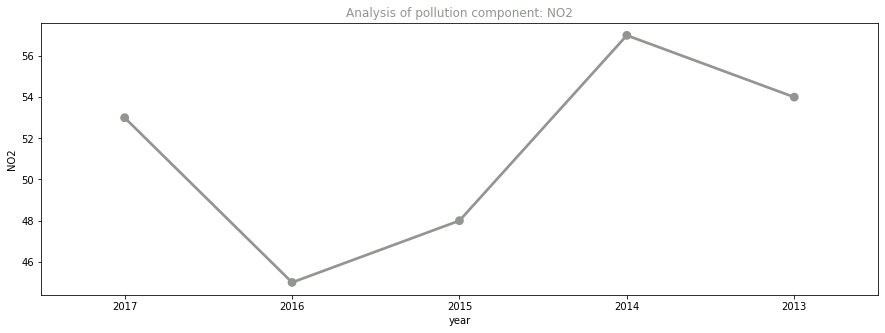

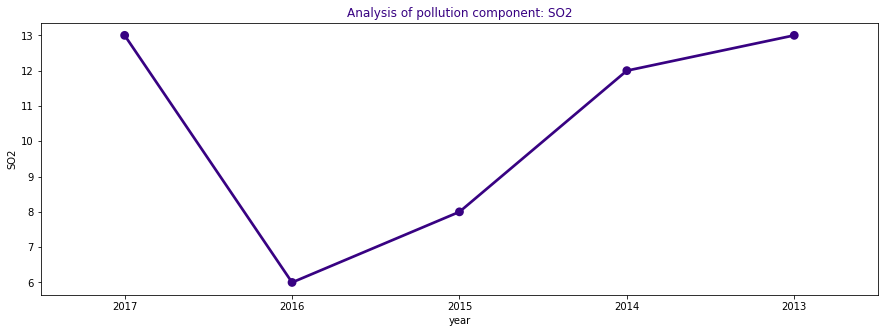

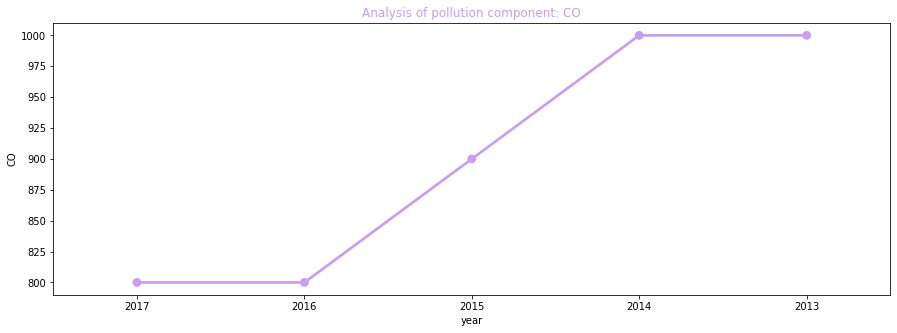

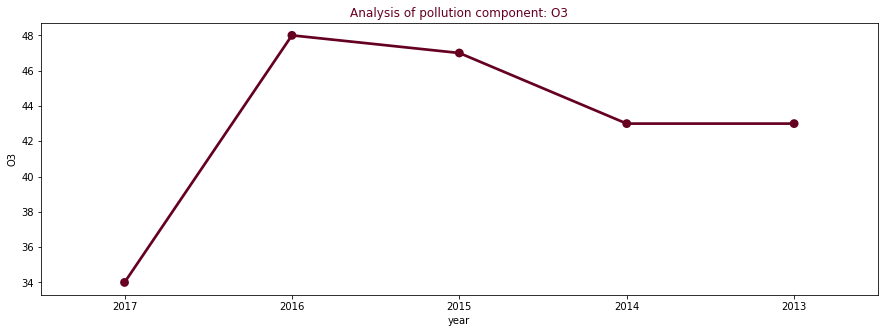

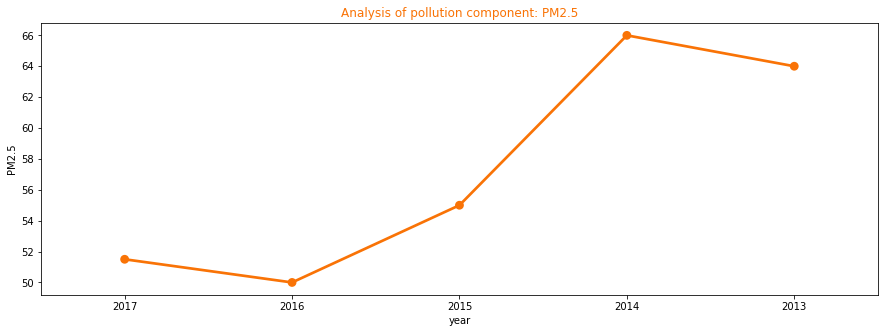

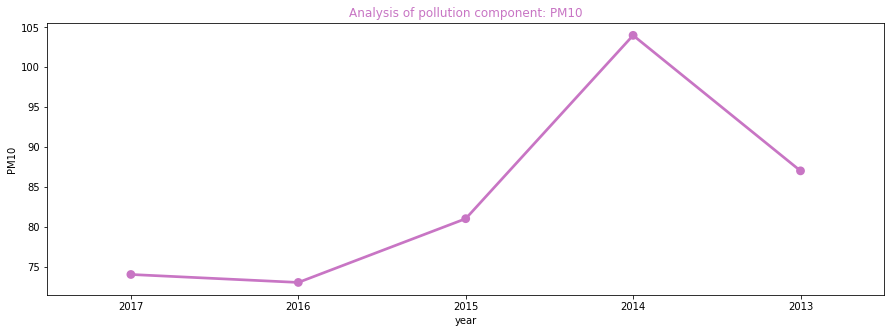

In [ ]:
for component, color_name in air_quality_components_and_colors_dictionary.items():
  temp_df = new_df[[component,'year']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
  f,ax=plt.subplots(figsize=(15,5))
  title = "Analysis of pollution component: " + component
  ax.set_title(title, color=color_name)
  sns.pointplot(x='year', y=component, data=temp_df, color=color_name)


---
SO2 and NO2 curves are going up in 2016-2017, after a dip from 2014 -> 2015 -> 
2016


---



### Correlation plot between Features (1 Point)

In [ ]:
clean_df = new_df

In [ ]:
clean_df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
year_month_day_hour,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
2013-03-01 01:00:00,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2013-03-01 02:00:00,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
2013-03-01 03:00:00,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


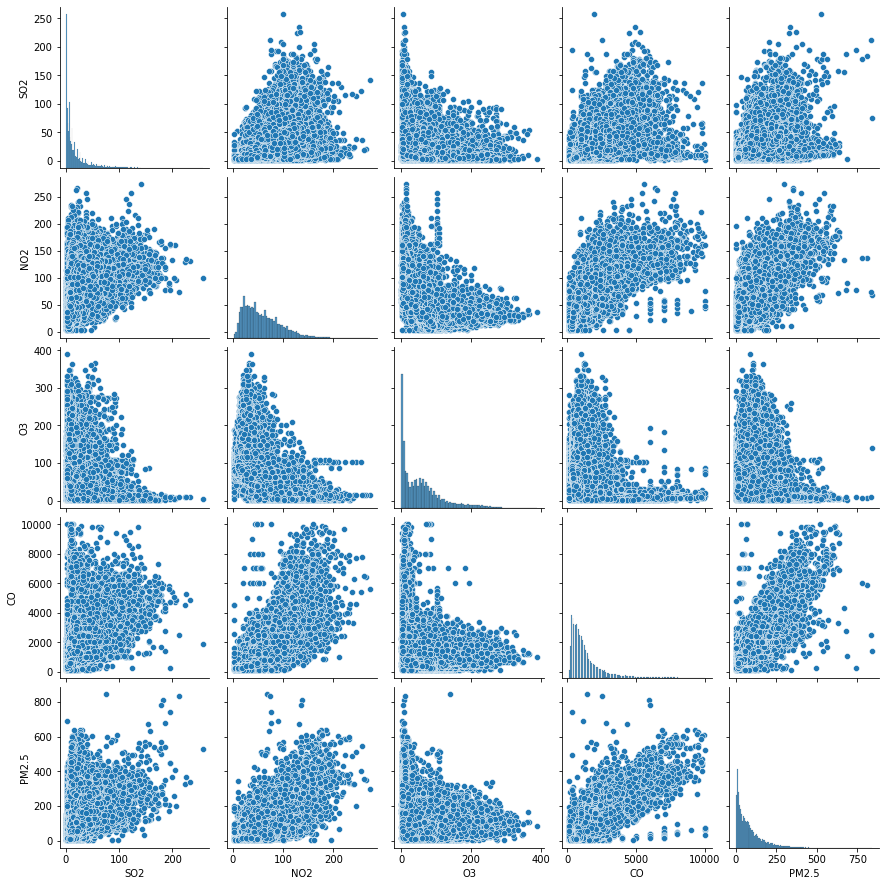

In [ ]:
g = sns.pairplot(clean_df[['SO2','NO2','O3','CO', 'PM2.5']])

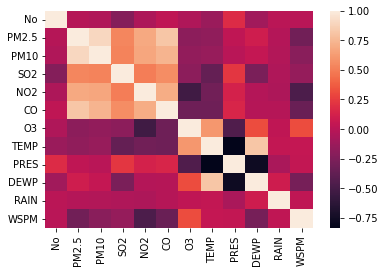

In [ ]:
# YOUR CODE HERE
sns.heatmap(clean_df.corr())

### Identify the trends and seasonality from the given time series data (1 Point)

Hint: `seasonal_decompose()`

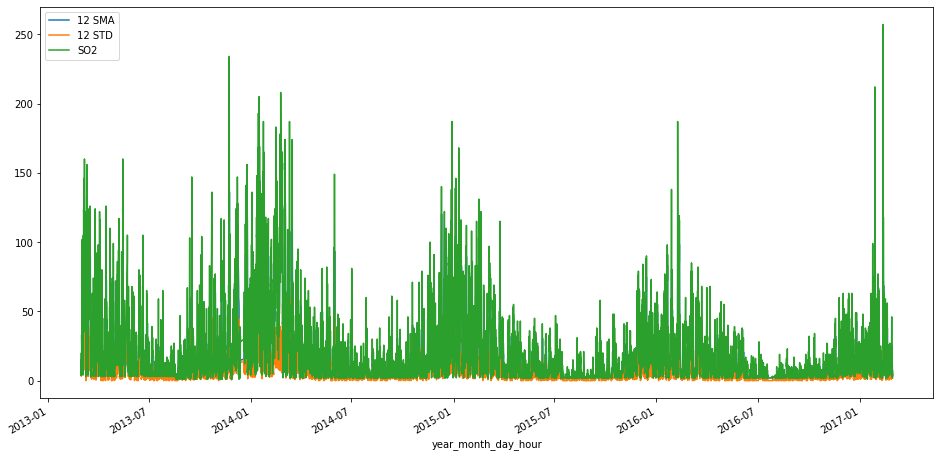

In [ ]:
# 12 month simple moving average and standard deviation
clean_df['SO2'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
clean_df['SO2'].rolling(12).std().plot(label='12 STD')
clean_df['SO2'].plot()
plt.legend()

In [ ]:
df_2017 = new_df['2017']
df_2017

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
year_month_day_hour,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,33649,2017,1,1,0,474.0,524.0,12.0,106.0,6400.0,11.0,-4.7,1022.1,-6.1,0.0,ENE,1.0,Nongzhanguan
2017-01-01 01:00:00,33650,2017,1,1,1,450.0,515.0,9.0,95.0,6700.0,15.0,-5.2,1022.3,-6.4,0.0,E,0.7,Nongzhanguan
2017-01-01 02:00:00,33651,2017,1,1,2,433.0,482.0,7.0,98.0,5800.0,9.0,-5.4,1022.5,-6.5,0.0,ENE,1.1,Nongzhanguan
2017-01-01 03:00:00,33652,2017,1,1,3,407.0,453.0,7.0,96.0,5900.0,8.0,-5.2,1022.5,-6.2,0.0,E,1.1,Nongzhanguan
2017-01-01 04:00:00,33653,2017,1,1,4,375.0,429.0,6.0,94.0,5800.0,13.0,-5.0,1021.9,-5.8,0.0,ENE,1.0,Nongzhanguan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,35060,2017,2,28,19,14.0,21.0,3.0,27.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Nongzhanguan
2017-02-28 20:00:00,35061,2017,2,28,20,18.0,27.0,3.0,37.0,400.0,59.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Nongzhanguan
2017-02-28 21:00:00,35062,2017,2,28,21,15.0,39.0,5.0,50.0,600.0,41.0,10.8,1014.2,-13.3,0.0,NW,1.1,Nongzhanguan


In [ ]:
def plot_graph_for_year(year:int):
  decomp = seasonal_decompose(clean_df[clean_df.year == year]['SO2'], freq=1)
  fig = decomp.plot()
  fig.set_size_inches(16,8)

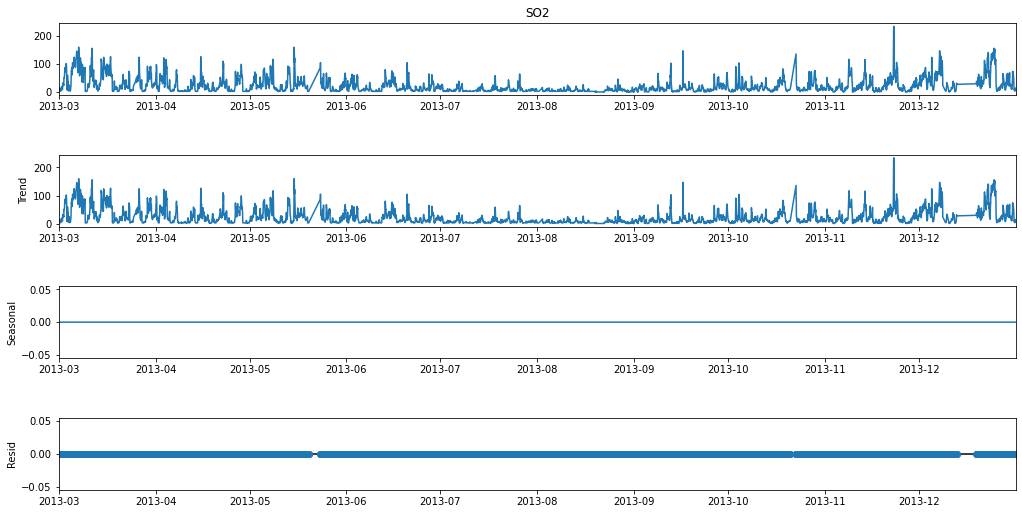

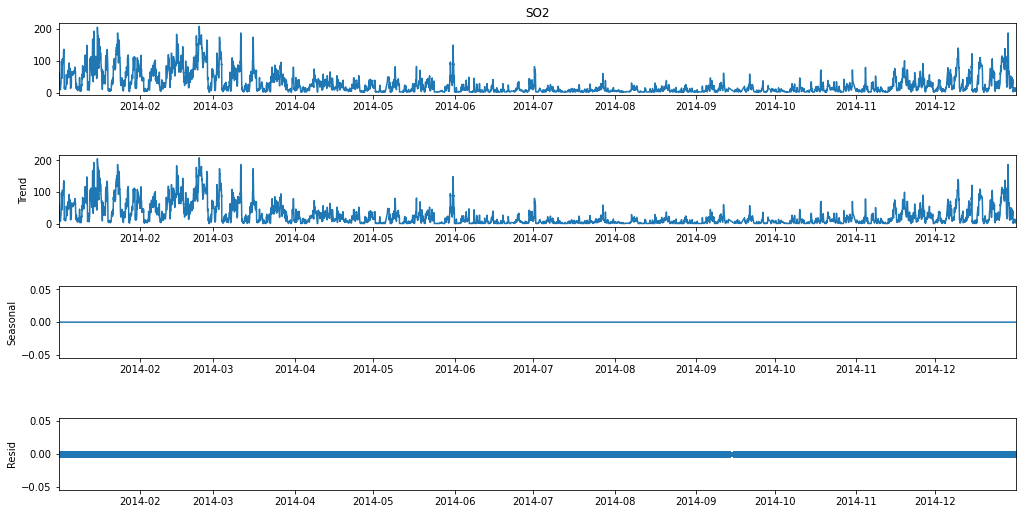

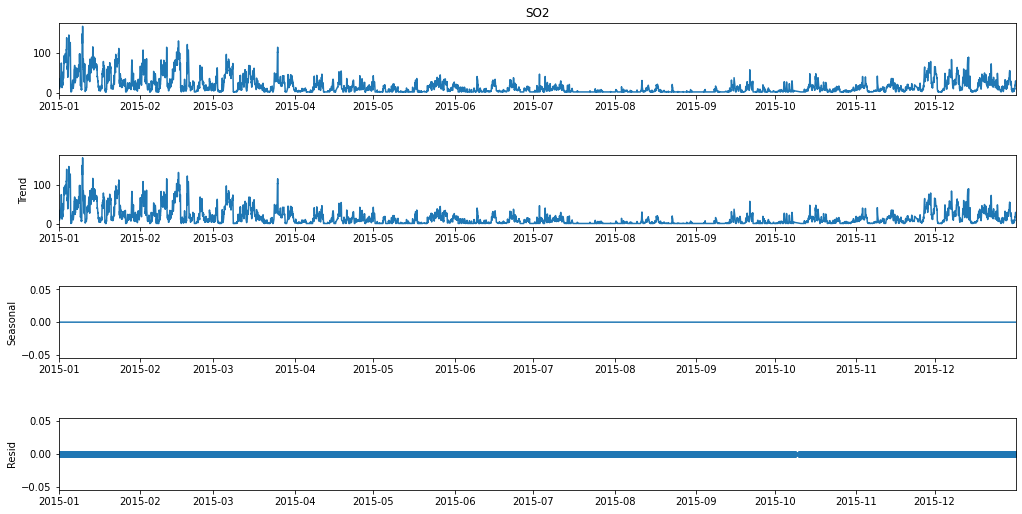

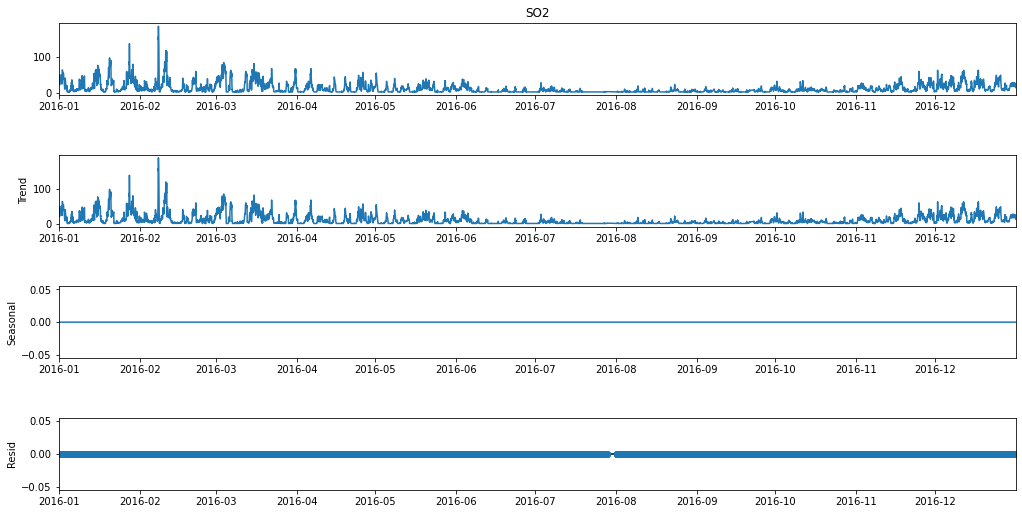

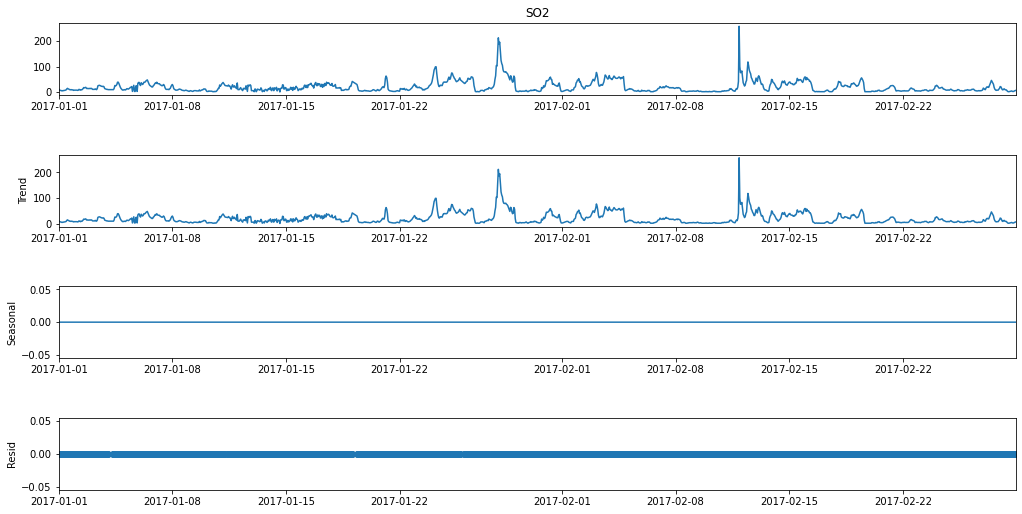

In [ ]:
for year in dataset_years:
  plot_graph_for_year(year)



---
Since the complete dataset is not showing any trend / seasonality, lets try with a subset of 2000 samples

---




In [ ]:
timeseries_slice = df_2017['PM2.5'][:2000]
timeseries_slice

year_month_day_hour
2017-01-01 00:00:00    474.0
2017-01-01 01:00:00    450.0
2017-01-01 02:00:00    433.0
2017-01-01 03:00:00    407.0
2017-01-01 04:00:00    375.0
                       ...  
2017-02-28 19:00:00     14.0
2017-02-28 20:00:00     18.0
2017-02-28 21:00:00     15.0
2017-02-28 22:00:00     11.0
2017-02-28 23:00:00     10.0
Name: PM2.5, Length: 1342, dtype: float64

<Figure size 432x288 with 0 Axes>

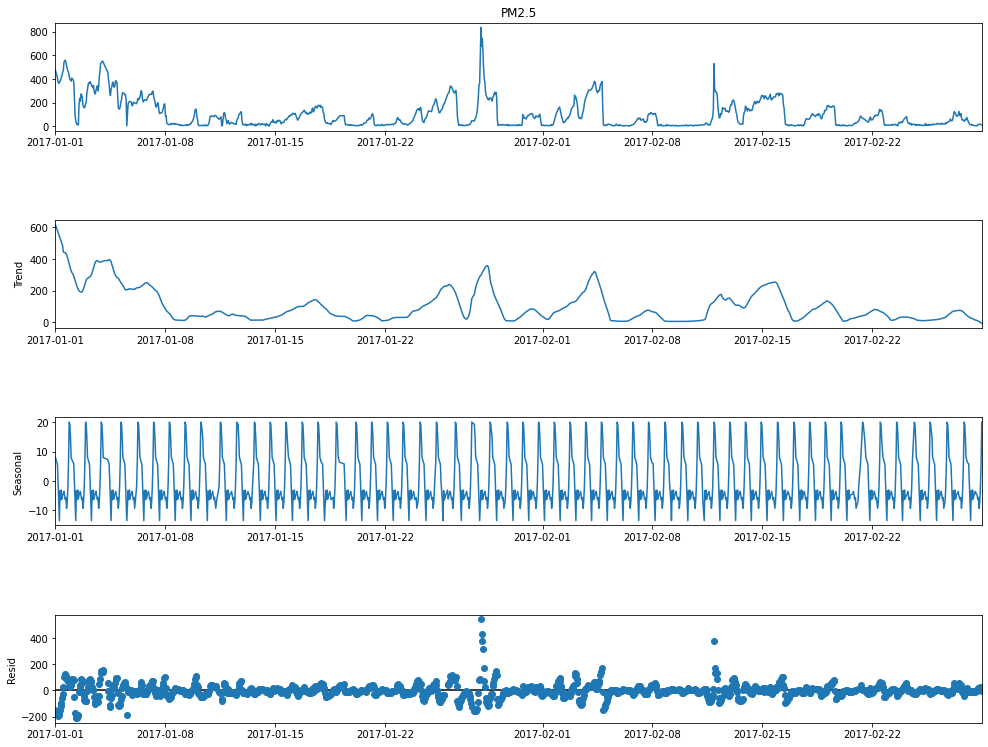

In [ ]:
# Decomposition of time series
result = seasonal_decompose(x=timeseries_slice, model='additive',extrapolate_trend='freq', period=24)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [ ]:
#Perform Dickey Fuller test    
result = adfuller(timeseries_slice)
print('ADF Stastistic: %f'%result[0])
print('p-value: %f'%result[1])
pvalue = result[1]
for key,value in result[4].items():
  if result[0]>value:
    print("The graph is non stationary")
    break
  else:
    print("The graph is stationary")
    break;
print('Critical values:')
for key,value in result[4].items():
    print('\t%s: %.3f ' % (key, value))

ADF Stastistic: -5.198319
p-value: 0.000009
The graph is stationary
Critical values:
	1%: -3.435 
	5%: -2.864 
	10%: -2.568 


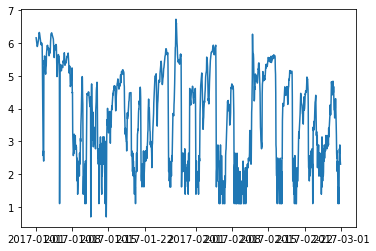

In [ ]:
df_log = np.log(timeseries_slice)
plt.plot(df_log)

In [ ]:
#Perform Dickey Fuller test for log(data)
result = adfuller(df_log)
print('ADF Stastistic: %f'%result[0])
print('p-value: %f'%result[1])
pvalue = result[1]
for key,value in result[4].items():
  if result[0]>value:
    print("The graph is non stationary")
    break
  else:
    print("The graph is stationary")
    break;
print('Critical values:')
for key,value in result[4].items():
    print('\t%s: %.3f ' % (key, value))

ADF Stastistic: -5.652551
p-value: 0.000001
The graph is stationary
Critical values:
	1%: -3.435 
	5%: -2.864 
	10%: -2.568 


<Figure size 432x288 with 0 Axes>

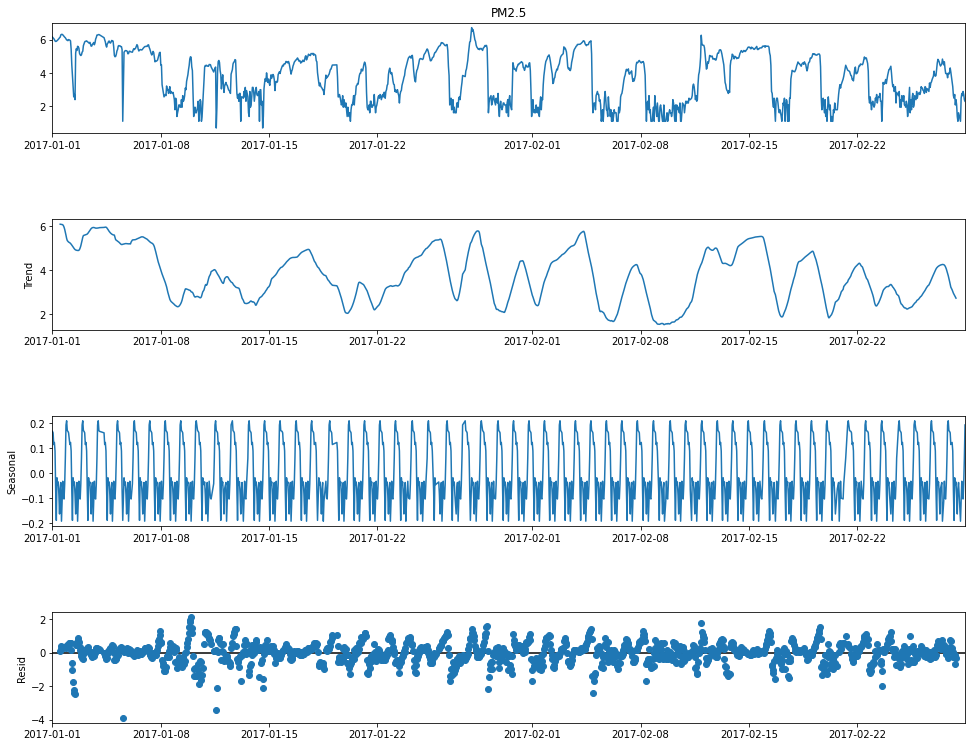

In [ ]:
# Decomposition of time series for log(data)
result = seasonal_decompose(x=df_log, model='additive', freq=24)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [ ]:
timeseries_diff = np.diff(timeseries_slice)

#### Summary Statistics based Stationary Check (full dataset)

In [ ]:
def calculate_mean_and_variance(component_name: str, data:Series):
  split = round(len(data) / 2)
  X1, X2 = data[:split], data[split:]
  mean1, mean2 = X1.mean(), X2.mean()
  var1, var2 = X1.var(), X2.var()
  print(f'\nCalculating Mean and Variance for {component_name}')
  print(f'mean-1 = {mean1}, mean-2 = {mean2}')
  print(f'variance-1 = {var1}, variance-2 = {var2}')

In [ ]:
for component in air_quality_components: calculate_mean_and_variance(component, clean_df[component])


Calculating Mean and Variance for NO2
mean-1 = 61.62528887479614, mean-2 = 54.80162469046325
variance-1 = 1362.986939821299, variance-2 = 1260.7423101169293

Calculating Mean and Variance for SO2
mean-1 = 24.977731473092952, mean-2 = 12.142664733949387
variance-1 = 862.975829886016, variance-2 = 217.20727359460537

Calculating Mean and Variance for CO
mean-1 = 1359.9838134927825, mean-2 = 1295.5849489641844
variance-1 = 1324306.4933354624, variance-2 = 1790502.975342268

Calculating Mean and Variance for O3
mean-1 = 56.25267090656517, mean-2 = 60.97713957842604
variance-1 = 3399.8529306141745, variance-2 = 3448.139200128567

Calculating Mean and Variance for PM2.5
mean-1 = 89.71624086489098, mean-2 = 79.72532463610557
variance-1 = 7210.594659509038, variance-2 = 7406.189977734958

Calculating Mean and Variance for PM10
mean-1 = 117.23021682671981, mean-2 = 101.12164039379114
variance-1 = 8965.609480099167, variance-2 = 8963.84155932872




---
Barring the SO2 values, there is not much difference in the mean and variance for other pollution components


---



#### Plot histogram for air quality components (full dataset)

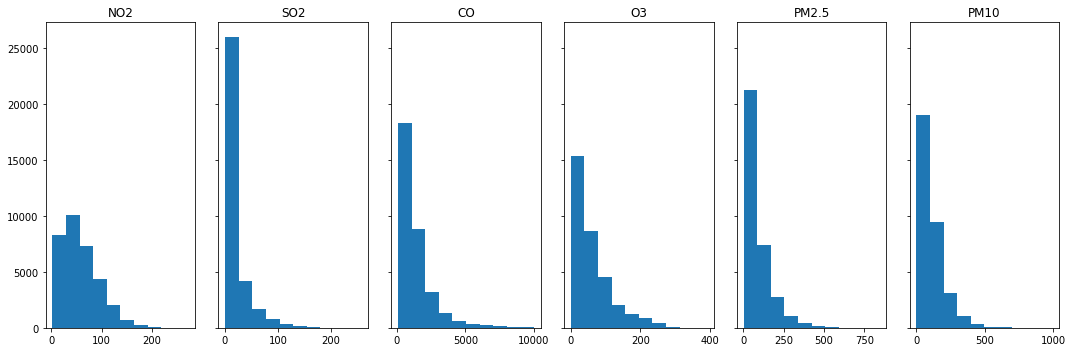

In [ ]:
fig, axs = plt.subplots(1,6, figsize=(15,5), sharey=True, tight_layout=True)
for idx, component in enumerate(get_air_quality_components()):
  axs[idx].hist(clean_df[component])
  axs[idx].set_title(component)  




---


The above distribution of values does not look Gaussian. This may be an indicator that its a non-stationary time series.

In the case of SO2, the decline is instant. 


---



#### Log transformation of (possibly) non-Gaussian dataset (full dataset)

**Do a log transformation to see if it helps in some way**

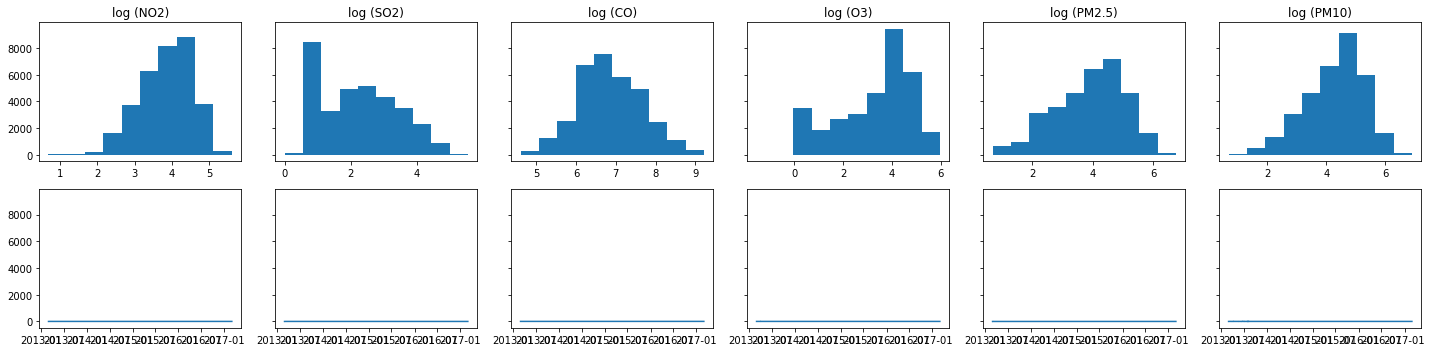

In [ ]:
fig, axs = plt.subplots(2,6, figsize=(20,5), sharey=True, tight_layout=True)
for idx, component in enumerate(get_air_quality_components()):
  log_df = log(clean_df[component])
  axs[0,idx].set_title("log (" + component + ")")  
  axs[0,idx].hist(log_df)
  axs[1,idx].plot(log_df)


### Time Series Stationarity (2 Points)

Check the Stationarity of time series using:
  * Dickey Fuller test
  * Rolling mean and Rolling standard deviation

Make the timeseries stationary

* Apply Log transformation and **Differencing** of the timeseries to make it stationary

Verify the stationarity with the Dickey Fuller test

In [ ]:
def test_stationarity_with_rolling_stats(pollution_component:str, data:Series, show_rolling_stats_plot:bool):
    #Determing rolling statistics
    rolling_mean = data.rolling(window=22,center=False).mean()
    rolling_std = data.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    if show_rolling_stats_plot: 
      orig = plt.plot(data, color='blue',label='Original')
      mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
      std = plt.plot(rolling_std, color='black', label = 'Rolling Std')

      plt.legend(loc='best')
      plt.title('Rolling Mean & Standard Deviation')
      plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result = adfuller(data,autolag='AIC', maxlag = 20)
    adf_statistic = result[0]
    print(f'ADF Statistic for {pollution_component}: {adf_statistic}')
    
    pvalue = result[1]
    print(f'p-value for {pollution_component}: {pvalue}')
    
    print('Critical values:')
    for key,value in result[4].items():
        print(f'\t{key}: {value}')
    
    for key,value in result[4].items():
         if adf_statistic > value:
            print(f"The data is non stationary\n")
            break
         else:
            print(f"The data is stationary\n")
            break;
    

In [ ]:
#test_stationarity_with_rolling_stats(clean_df['SO2'])
for component in air_quality_components: test_stationarity_with_rolling_stats(pollution_component=component,
                                                                              data=clean_df[component],
                                                                              show_rolling_stats_plot=False)

ADF Statistic for NO2: -18.40234619037555
p-value for NO2: 2.191278241551446e-30
Critical values:
	1%: -3.430547619052661
	5%: -2.8616273425793683
	10%: -2.5668164897374672
The data is stationary

ADF Statistic for SO2: -17.376332470359575
p-value for SO2: 5.1030861934812755e-30
Critical values:
	1%: -3.430547619052661
	5%: -2.8616273425793683
	10%: -2.5668164897374672
The data is stationary

ADF Statistic for CO: -19.827889545389382
p-value for CO: 0.0
Critical values:
	1%: -3.4305476071092023
	5%: -2.86162733730084
	10%: -2.56681648692784
The data is stationary

ADF Statistic for O3: -12.14323456655603
p-value for O3: 1.632733312842493e-22
Critical values:
	1%: -3.430547619052661
	5%: -2.8616273425793683
	10%: -2.5668164897374672
The data is stationary

ADF Statistic for PM2.5: -22.080808046593333
p-value for PM2.5: 0.0
Critical values:
	1%: -3.4305475891967205
	5%: -2.861627329384244
	10%: -2.5668164827140365
The data is stationary

ADF Statistic for PM10: -22.159950151748298
p-valu



---
For all the pollution components, the ADF statistics is lower than all critical values - 0.01, 0.05, 0.10.

Clear indication that the data is already stationary for the complete dataset size.

---





In [ ]:
# Let’s create a function to run the test which determines whether a given time series is stationary
def get_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=24).mean()
    rolling_std = timeseries.rolling(window=24).std()
    
    # Rolling statistics plot
    plt.figure(figsize=(15,5))
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

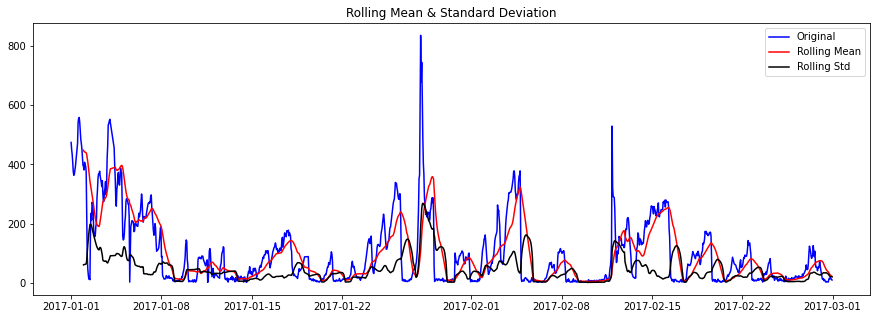

In [ ]:
get_stationarity(timeseries_slice)

### Auto Correlation Plot Analysis ( 2 Points)

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time (e.g.,temperature measured on different days of the month, hours of the day).  For example, one might expect the air temperature on the $1^{st}$ day of the month to be more similar to the temperature on the $2^{nd}$ day compared to the $31^{st}$ day.  If the temperature values that occurred closer together in time are, in fact, more similar than the temperature values that occurred farther apart in time, the data would be autocorrelated.

Autocorrelation can cause problems in conventional analyses (such as ordinary least squares regression) that assume independence of observations.

In a regression analysis, autocorrelation of the regression residuals can also occur if the model is incorrectly specified.  For example, if you are attempting to model a simple linear relationship but the observed relationship is non-linear (i.e., it follows a curved or U-shaped function), then the residuals will be autocorrelated.

* Plot ACF and PACF graphs 
* Analyse and identify the ARIMA (p, d, q) terms

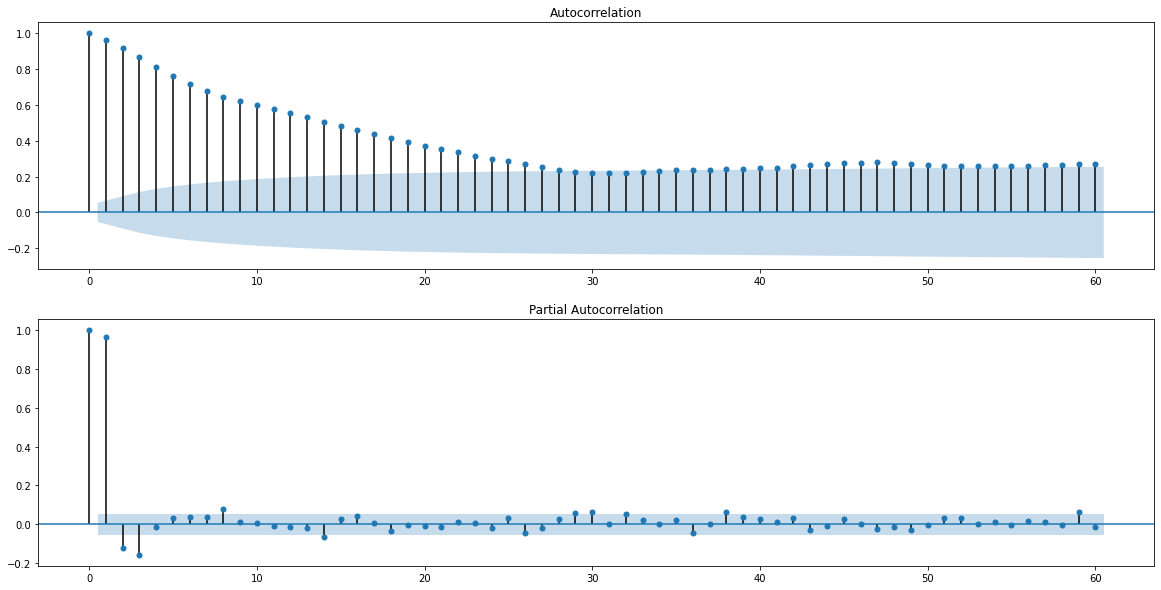

In [ ]:
# let us plot acf and pacf graphs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize = (20,10))
plt.subplot(211)
plot_acf(timeseries_slice, ax=plt.gca(), lags = 60)
plt.subplot(212)
plot_pacf(timeseries_slice, ax=plt.gca(), lags = 60)
plt.show()

In [ ]:
timeseries = timeseries_slice

In [ ]:
model = ARIMA(timeseries, order=(2,0,2))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1342
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6432.885
Date:                Sun, 27 Mar 2022   AIC                          12877.771
Time:                        16:13:50   BIC                          12908.982
Sample:                             0   HQIC                         12889.463
                               - 1342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.6847     29.671      3.360      0.001      41.531     157.838
ar.L1          1.3176      0.102     12.874      0.000       1.117       1.518
ar.L2         -0.3546      0.102     -3.489      0.0

In [ ]:
model2 = ARIMA(timeseries, order=(2,0,0))
model2_fit = model2.fit()
# summary of fit model
print(model2_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1342
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -6453.283
Date:                Sun, 27 Mar 2022   AIC                          12914.566
Time:                        16:14:10   BIC                          12935.373
Sample:                             0   HQIC                         12922.360
                               - 1342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.6907     33.454      2.980      0.003      34.122     165.259
ar.L1          1.1033      0.006    179.977      0.000       1.091       1.115
ar.L2         -0.1374      0.007    -18.477      0.0

In [ ]:
model3 = ARIMA(timeseries, order=(2,1,2))
model3_fit = model3.fit()
# summary of fit model
print(model3_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1342
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6443.246
Date:                Sun, 27 Mar 2022   AIC                          12896.491
Time:                        16:14:28   BIC                          12922.497
Sample:                             0   HQIC                         12906.234
                               - 1342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3878      0.140      2.776      0.006       0.114       0.662
ar.L2         -0.1390      0.110     -1.260      0.208      -0.355       0.077
ma.L1         -0.2844      0.140     -2.037      0.0

In [ ]:
model4 = ARIMA(timeseries, order=(2,1,0))
model4_fit = model4.fit()
# summary of fit model
print(model4_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1342
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6444.854
Date:                Sun, 27 Mar 2022   AIC                          12895.708
Time:                        16:14:42   BIC                          12911.311
Sample:                             0   HQIC                         12901.553
                               - 1342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1017      0.006     16.935      0.000       0.090       0.114
ar.L2          0.1451      0.016      8.838      0.000       0.113       0.177
sigma2       875.6224      6.600    132.669      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
model5 = ARIMA(timeseries, order=(4,1,1))
model5_fit = model5.fit()
# summary of fit model
print(model5_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1342
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -6423.774
Date:                Sun, 27 Mar 2022   AIC                          12859.548
Time:                        16:14:59   BIC                          12890.755
Sample:                             0   HQIC                         12871.239
                               - 1342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0463      0.012     88.964      0.000       1.023       1.069
ar.L2          0.0559      0.019      2.911      0.004       0.018       0.094
ar.L3         -0.1469      0.023     -6.287      0.0

In [ ]:
# YOUR CODE HERE
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame

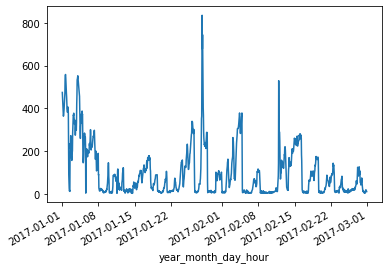

In [ ]:
timeseries.plot()
pyplot.show()

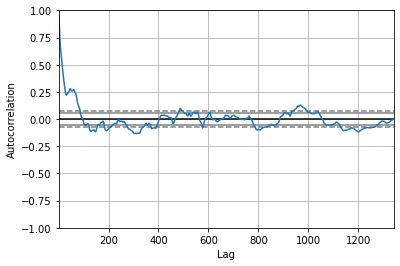

In [ ]:
autocorrelation_plot(timeseries)
pyplot.show()

### Implement ARIMA model (2 Points)

* Fit the timeseries data with ARIMA
* Find and interpret the loss (AIC)

In [ ]:
print(model5_fit.aic)   

predictions = model5_fit.predict()  
error = sqrt(mean_squared_error(timeseries, predictions))
print('RMSE value: %.3f' % error)

12859.548044784773
RMSE value: 31.854


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


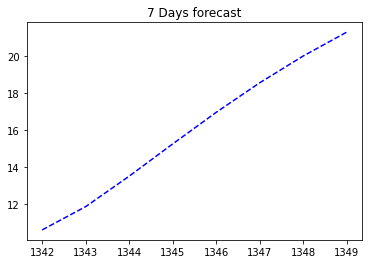

In [ ]:
future = model5_fit.predict(start=len(timeseries),end=len(timeseries)+7)
plt.title("7 Days forecast")
plt.plot(future.index, future, color='blue', linestyle='dashed')
plt.show()

**ARIMA Model in Iterative process**

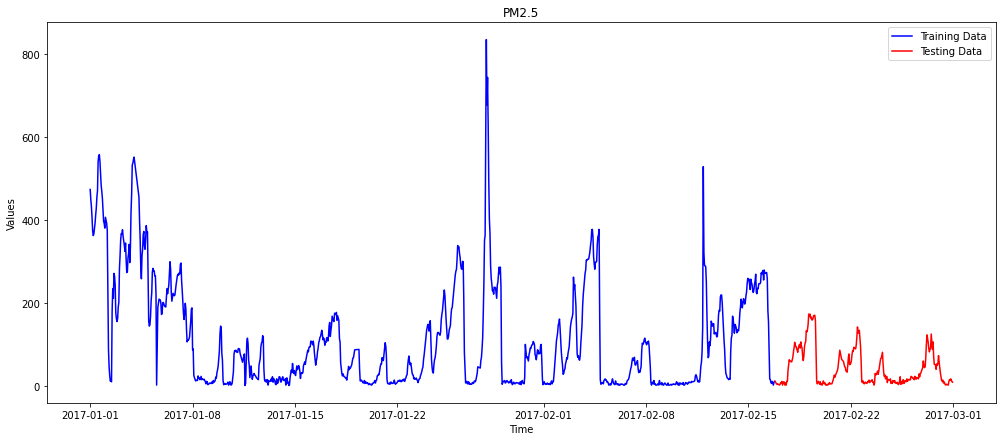

In [ ]:
train_data, test_data = timeseries[0:int(len(timeseries)*0.8)], timeseries[int(len(timeseries)*0.8):] # Train and test split
plt.figure(figsize=(17,7))
plt.title('PM2.5')
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(train_data, 'blue', label='Training Data') #Plot train data in blue color
plt.plot(test_data, 'red', label='Testing Data')  # Plot test data in red color
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()
plt.show()

In [ ]:
# Function to Calculate the mean absolute percentage error
# The mean absolute percentage error (MAPE) is a statistical measure of how accurate a forecast system is.
# It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time 
# period minus actual values divided by actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# ARIMA model

# YOUR CODE HERE for train and test data close value
train_ar = train_data.values
test_ar = test_data.values

history = [x for x in train_ar]

predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(4,1,1)) 
    model_fit = model.fit()  
    # Above, disp=0 setting turns off the large amount of debug information provided
    # regarding the fit of the regression model.
    output = model_fit.forecast() # one-step forecast
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=24.187432, expected=12.000000
predicted=23.289700, expected=9.000000
predicted=19.099377, expected=6.000000
predicted=15.282142, expected=5.000000
predicted=14.159977, expected=6.000000
predicted=15.445312, expected=5.000000
predicted=14.421389, expected=4.000000
predicted=12.898889, expected=3.000000
predicted=11.601081, expected=5.000000
predicted=13.607238, expected=9.000000
predicted=17.940621, expected=8.000000
predicted=16.613615, expected=12.000000
predicted=19.911094, expected=3.000000
predicted=10.284626, expected=7.000000
predicted=13.246580, expected=11.000000
predicted=18.721833, expected=10.000000
predicted=17.480219, expected=3.000000
predicted=8.967295, expected=8.000000
predicted=13.674669, expected=3.000000
predicted=9.527360, expected=12.000000
predicted=18.214101, expected=12.000000
predicted=19.108159, expected=38.000000
predicted=45.603479, expected=50.000000
predicted=59.474032, expected=64.000000
predicted=71.154973, expected=61.000000
predicted=65.7925

In [ ]:
# for calculating the MAPE (error)
error = mean_absolute_percentage_error(test_ar, predictions)
print('Mean absolute percentage error: %.3f' % error)

Mean absolute percentage error: 50.556


(array([  2.,   5.,  59., 185.,  18.]),
 array([-74.38526698, -51.91608321, -29.44689945,  -6.97771568,
         15.49146808,  37.96065185]),
 <a list of 5 Patch objects>)

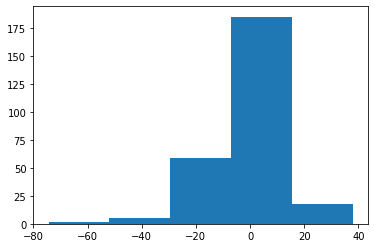

In [ ]:
errors = test_ar -  predictions
plt.hist(errors, bins = 5)

#### Plot the predictions

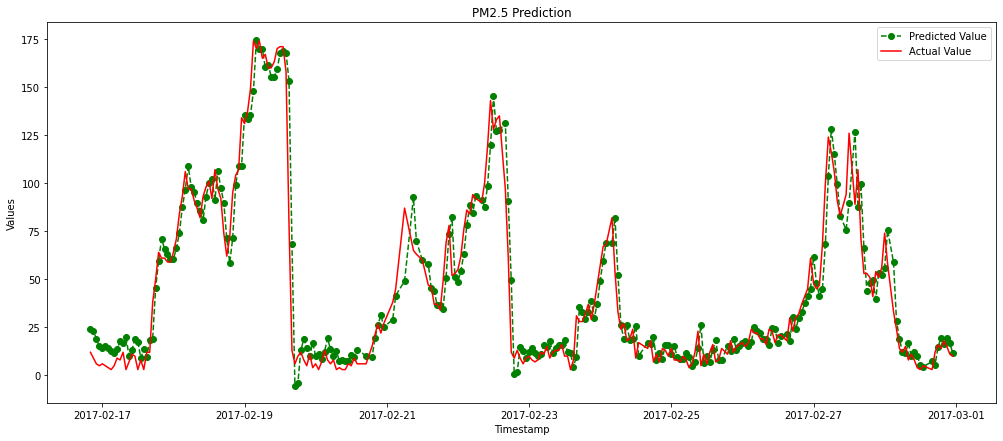

In [ ]:
plt.figure(figsize=(17,7))
#plt.plot(train_data, 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green',marker='o', linestyle='dashed', label='Predicted Value')
plt.plot(test_data.index, test_data, color='red', label='Actual Value')
plt.title('PM2.5 Prediction')
plt.xlabel('Timestamp')
plt.ylabel('Values')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()

### Implement SARIMAX model (optional)

A SARIMA model can be tuned with two kinds of orders: (p,d,q) order, which refers to the order of the time series. This order is also used in the ARIMA model (which does not consider seasonality); (P,D,Q,S) seasonal order, which refers to the order of the seasonal component of the time series.

$\color{blue}{\text{Note: Implementing SARIMAX in Colab may crash the session as it may run out of RAM.}}$


$\color{blue}{\text{Alternatively you could use (free) AWS Sagemaker StudioLab. Refer to AWS Sagemaker StudioLab introductory video }}$ 

$$\href{https://drive.google.com/file/d/1zXuLe4rjUG8-2Yz1kWJcWbZk8R94sQM5/view?usp=sharing}{Click Here}$$


In [ ]:
# Fit the SARIMA model
# YOUR CODE HERE

#### Plot the predictions

In [ ]:
# predicting with SARIMA
# YOUR CODE HERE

### Report Analysis

* Comment on the trend and seasonality of the time series data
* Comment on results of the Dickey Fuller test analysis
* Is the air quality becoming poorer across the years?
* Do we see spikes indicating poor air quality in particular periods each year? What could be the reasons?

For related reading, refer to: [Time Series Analysis of PM 2.5 in Beijing](https://ionides.github.io/531w20/midterm_project/project11/midterm-project.html)